In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
%matplotlib inline

import torch
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
#from torchvision.transforms import functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import WeightedRandomSampler
from dataclasses import dataclass
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import os

from PIL import Image

%matplotlib inline


DATA_ROOT = "/kaggle/input/pytorch-opencv-course-classification/"
#IMAGES_ROOT = DATA_ROOT + '/images/images/'

In [ ]:
def image_common_transforms():
    common_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
        ])        
    
    return common_transforms

In [ ]:
def image_training_transforms():
    common_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
        ])        
    return common_transforms

In [ ]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = dataset_obj.idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

In [ ]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj, is_validation):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
#    print(count_dict)
    
#    for _,j in dataloader_obj:
        
#        y_idx = j.item()
#        y_lbl = dataset_obj.idx2class[y_idx]
#        count_dict[str(y_lbl)] += 1
        
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = dataset_obj.idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
            if is_validation == True:
                dataset_obj.set_validation(y_idx)
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = dataset_obj.idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
                if is_validation == True:
                    dataset_obj.set_validation(y_idx)

            
    return count_dict

In [ ]:
def get_target_list_loaders(dataloader_obj):
    target_list = []
    
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            target_list.append(y_idx)
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                target_list.append(y_idx)
                
    return target_list

**Check class balance**

13
Num labels 6536 num classes 13 avg count per class 502.7692307692308


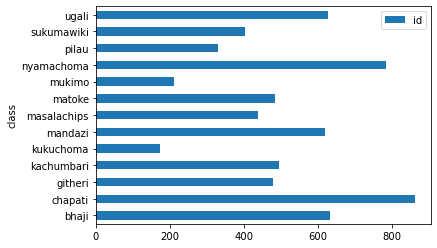

In [ ]:
label_csv_path = os.path.join(DATA_ROOT, 'train.csv')
labels_df = pd.read_csv(label_csv_path)

num_total_classes = len(labels_df['class'].unique())
print(num_total_classes)
avg_count_per_class = len(labels_df)/num_total_classes

print("Num labels {} num classes {} avg count per class {}".format(len(labels_df), num_total_classes, avg_count_per_class))
labels_df.groupby('class').nunique().plot(kind='barh')

**Some classes have a lot fewer images than the average. We wil have to generate synthetic data for these. Find out the classes that are 20% below the average (number of images)**

**1. Data Loader**

In [ ]:
from torch.utils.data.dataset import random_split

class KenyanFood13Dataset(Dataset):
    """

    """

    def __init__(self, data_root, transform=None):
        label_csv_path = os.path.join(data_root, 'train.csv')
        self.label_df = pd.read_csv(label_csv_path)
#        print(len(self.label_df))
        
        # set transform attribute
        self.transform = transform
        self.validation_transform = None
        
        num_classes = self.label_df['class'].unique()
        self.classes_list = num_classes.tolist()
#        print(num_classes)
#        print(len(num_classes))
        print(self.classes_list)
        
        self.idx2class = {i: key for i, key in enumerate(self.classes_list)}
        self.class_to_idx = {key: i for i, key in enumerate(self.classes_list)}
        print("=====")
        print(self.class_to_idx)
        
        with open('./labels.csv', 'w') as f:
            for key in self.idx2class.keys():
                f.write("%d,%s\n"%(key,self.idx2class[key]))
        
        
        self.data_dict = {
            'image_path': [],
            'label': [],
            'is_train':[]
        }
        
        img_dir = os.path.join(data_root, 'images', 'images')

        for index, row in self.label_df.iterrows():
            img_path = os.path.join(img_dir, '{}.jpg'.format(row[0]))
            self.data_dict['image_path'].append(img_path)
            self.data_dict['label'].append(self.class_to_idx[row[1]])#self.classes_list.index(row[1]))
            self.data_dict['is_train'].append(True)

    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing.
        """
        
        image = Image.open(self.data_dict['image_path'][idx]).convert("RGB")
        
        if self.data_dict['is_train'][idx] == True:
            if self.transform is not None:
                image = self.transform(image)
        else:
            if self.validation_transform is not None:
                image = self.validation_transform(image)
            
            
        target = self.data_dict['label'][idx]
        
        return image, target
    
    def __len__(self):
        return len(self.data_dict['label'])
    
    def set_validation(self, idx):
        self.data_dict['is_train'][idx] = False
    
    def set_validation_transform(self, transform):
        self.validation_transform = transform

    
        
    def get_targets():
        
        targets = []
        
        for key, value in self.class_to_idx:
            targets.append(value)
            
        return targets
    
    




def get_data(batch_size, data_root, num_workers=1):
    
    dataset =  KenyanFood13Dataset(data_root, transform=image_training_transforms())
#    dataset =  KenyanFood13Dataset(data_root, transform=image_common_transforms())

    dataset.set_validation_transform(image_common_transforms())
    
#    validation_split = .2
#    random_seed= 42
    dataset_size = len(dataset)
    print('Total dataset size {}'.format(dataset_size))
#    indices = list(range(dataset_size))
#    split = int(np.floor(validation_split * dataset_size))
#    np.random.seed(random_seed)
#    np.random.shuffle(indices)
#    train_indices, val_indices = indices[split:], indices[:split]
    
    train_len = int(0.8*len(dataset))
    valid_len = len(dataset) - train_len    
    
    train_dataset, val_dataset = random_split(dataset, [train_len, valid_len])
    print('Train dataset size {}, test dataset size {}'.format(len(train_dataset), len(val_dataset)))

#    train_sampler = SubsetRandomSampler(train_indices)
#    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, 
                                                shuffle=False, num_workers=num_workers)
#                                               sampler=train_sampler, shuffle=False, num_workers=num_workers)
    validation_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1,
                                                    shuffle=False, num_workers=num_workers)
#                                                    sampler=valid_sampler, shuffle=False, num_workers=num_workers)

    train_class_distribution = get_class_distribution_loaders(train_loader, dataset, is_validation=False)
    validation_class_distribution = get_class_distribution_loaders(validation_loader, dataset, is_validation=True)
    
    print(train_class_distribution)
    print(validation_class_distribution)
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
    sns.barplot(data = pd.DataFrame.from_dict([train_class_distribution]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Train Set')
    sns.barplot(data = pd.DataFrame.from_dict([validation_class_distribution]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Val Set')


    train_elements_count = 0
    validation_elements_count = 0
    class_count_train = []
    class_count_validation = []
    
    for key, value in train_class_distribution.items():
        train_elements_count += value
        class_count_train.append(value)
        
    print(class_count_train)
    
    for key, value in validation_class_distribution.items():
        validation_elements_count += value
        class_count_validation.append(value)
        
    print(class_count_validation)
    
    print("Train elements count {}".format(train_elements_count))
    

    print("Validation elements count {}".format(validation_elements_count))
   
    
    class_weights_train = 1./torch.tensor(class_count_train, dtype=torch.float)
    class_weights_validation = 1./torch.tensor(class_count_validation, dtype=torch.float)
    
    print("Class weights train {}".format(class_weights_train))
    print("Class weights validation {}".format(class_weights_validation))
    
    target_list_train = get_target_list_loaders(train_loader)
    target_list_validation = get_target_list_loaders(validation_loader)
    
    print("Target list len {} {} {} {} ".format(len(target_list_train), target_list_train[0], target_list_train[5], target_list_train[15]))
    print("Validation list len {} {} {} {} ".format(len(target_list_train), target_list_validation[0], target_list_validation[5], target_list_validation[15]))
    
    
    class_weights_all_train = class_weights_train[target_list_train]
    class_weights_all_validation = class_weights_validation[target_list_validation]
    
    print(class_weights_all_validation)
    
    weighted_sampler_train = WeightedRandomSampler(weights=class_weights_all_train, num_samples=len(class_weights_all_train), replacement=True)
    weighted_sampler_validation = WeightedRandomSampler(weights=class_weights_all_validation, num_samples=len(class_weights_all_validation), replacement=True)
    
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, 
                                               sampler=weighted_sampler_train, shuffle=False, num_workers=num_workers)
    validation_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size,
                                                    sampler=weighted_sampler_validation, shuffle=False, num_workers=num_workers)
    
    
#    class_count = [i for i in get_class_distribution(dataset).values()]
    
#    print("Class count")
#    print(class_count)
    
#    plt.rcParams["figure.figsize"] = (15, 9)
#    plt.figure
#    for images, labels in validation_loader:
#        for i in range(15):
#            plt.subplot(3, 5, i+1)
#            img = F.to_pil_image(images[i])
#            plt.imshow(img)
#            plt.gca().set_title('Target: {0}'.format(labels[i]))
#        plt.show()
#        break
        
    return train_loader, validation_loader, class_weights_train, class_weights_validation


**2. Configuration**

In [ ]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [ ]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 16  
    epochs_count: int = 50  
    init_learning_rate: float = 1e-4  # initial learning rate for lr scheduler
    decay_rate: float = 1e-5  
    log_interval: int = 500  
    test_interval: int = 1  
    data_root: str = DATA_ROOT 
    num_workers: int = 8  
    device: str = 'cuda'  

**3. Evaluation Metrics**

In [ ]:
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])

**4. Train and Validation functions**

In [ ]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int, loss_weights: torch.tensor
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
    
    loss_weights = loss_weights.to(train_config.device)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target, weight=loss_weights)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

In [ ]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
    loss_weights: torch.tensor
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    loss_weights = loss_weights.to(train_config.device)
    
    for data, target in test_loader:
        indx_target = target.clone()
        
        
        
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target, weight=loss_weights).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

****5. Model****

In [ ]:
model = models.resnet34(pretrained=True)#models.vgg19(pretrained=True)#models.resnet101(pretrained=True)#models.vgg19(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#classifier = nn.Sequential(
#        nn.Linear(in_features=25088, out_features=4096, bias=True),
#        nn.ReLU(inplace=True),
#        nn.Dropout(p=0.4, inplace=False),
#        nn.Linear(in_features=4096, out_features=2048, bias=True),
#        nn.ReLU(inplace=True),
#        nn.Dropout(p=0.4, inplace=False),
#        nn.Linear(in_features=2048, out_features=1024, bias=True),
#        nn.ReLU(inplace=True),
#        nn.Dropout(p=0.4, inplace=False),
#        nn.Linear(in_features=1024, out_features=13, bias=True)
#    )

for name, child in model.named_children():
   if name in ['layer3', 'layer4']:
       print(name + ' is unfrozen')
       for param in child.parameters():
           param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False

#classifier_densenet = nn.Sequential(
#        nn.Linear(in_features=25088, out_features=4096, bias=True),
#        nn.ReLU(inplace=True),
#        nn.Dropout(p=0.4, inplace=False),
#        nn.Linear(in_features=4096, out_features=2048, bias=True),
#        nn.ReLU(inplace=True),
#        nn.Dropout(p=0.4, inplace=False),
#        nn.Linear(in_features=2048, out_features=1024, bias=True),
#        nn.ReLU(inplace=True),
#        nn.Dropout(p=0.4, inplace=False),
#        nn.Linear(in_features=1024, out_features=13, bias=True)
#    )

#for param in model.parameters():
#    param.requires_grad = False
    
num_ftrs = model.fc.in_features

print("Num features {}".format(num_ftrs))

#classifier = nn.Sequential(
#  nn.Linear(in_features=num_ftrs, out_features=1024),
#  nn.LeakyReLU(),
#  nn.Dropout(p=0.2),
#  nn.Linear(in_features=1024, out_features=512),
#  nn.LeakyReLU(),
#  nn.Dropout(p=0.3),
#  nn.Linear(in_features=512, out_features=13)
#)

model.fc = torch.nn.Linear(num_ftrs, 13)
#model.fc = classifier
    
#model.classifier = classifier
#model.fc

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is frozen
Num features 512


**6. Utils**

**Save Model**

In [ ]:
def save_model(model, device, model_dir='./', model_file_name='kenyan13foods34.pt'):
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return

**Load Model**

In [ ]:
def load_model(model, model_dir='./', model_file_name='kenyan13foods34.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model

**Setup System**

In [ ]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

**Plot train and validation accuracy**

In [ ]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    plt.show()
    
    return   

**Main training function**

In [ ]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration()):
    
    e_train_loss = np.array([])
    e_test_loss = np.array([])
    e_train_acc = np.array([])
    e_test_acc = np.array([])
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader, train_weights, validation_weights = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        
    )
    
    plt.rcParams["figure.figsize"] = (15, 9)
    plt.figure
    for images, labels in test_loader:
        for i in range(15):
            plt.subplot(3, 5, i+1)
            img = transforms.functional.to_pil_image(images[i])
            plt.imshow(img)
            plt.gca().set_title('Target: {0}'.format(labels[i]))
        plt.show()
        break    
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    
    # Calculate Initial Test Loss
    init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader, validation_weights)
    print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss, 
                                                                                   init_val_accuracy*100))
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch, train_weights)
        
        print("Epoch {}  train loss {}".format(epoch, train_loss))
        
        e_train_loss = np.append(e_train_loss, [train_loss])
        
        e_train_acc = np.append(e_train_acc, [train_acc])
        
        print("Global Epoch train loss len {}".format(len(e_train_loss)))

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader, validation_weights)
            
            e_test_loss = np.append(e_test_loss, [current_loss])
            
            print("Epoch {}  test loss {}".format(epoch, current_loss))
            print("Global Epoch test loss len {}".format(len(e_test_loss)))
        
            e_test_acc = np.append(e_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)
        
        if scheduler is not None:
#            scheduler.step(current_loss)
            scheduler.step()
        
#    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_, loss))
    print("before exit losses len {} {} {} {}".format(len(e_train_loss), len(e_test_loss), len(e_train_acc), len(e_test_acc)))
    
    return model, train_loader, test_loader, e_train_loss, e_test_loss, e_train_acc, e_test_acc

**Plot loss accuracy**

In [ ]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    fig.savefig('sample_loss_acc_plot.png')
    plt.show()
    
    return   

In [ ]:
train_config = TrainingConfiguration()

#optimizer = optim.SGD(
#        model.parameters(),
#        lr=train_config.init_learning_rate
#)

#optimizer = optim.Adam(
#    model.parameters(),
#    lr = train_config.init_learning_rate,
#    weight_decay=train_config.decay_rate
#)


#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)
#decay_rate = train_config.decay_rate

#lmbda = lambda epoch: 1/(1 + decay_rate * epoch)

    # Scheduler
#scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)

#optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

optimizer = optim.SGD(filter(lambda x: x.requires_grad, model.parameters()), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

['githeri', 'ugali', 'kachumbari', 'matoke', 'sukumawiki', 'bhaji', 'mandazi', 'kukuchoma', 'nyamachoma', 'pilau', 'chapati', 'masalachips', 'mukimo']
=====
{'githeri': 0, 'ugali': 1, 'kachumbari': 2, 'matoke': 3, 'sukumawiki': 4, 'bhaji': 5, 'mandazi': 6, 'kukuchoma': 7, 'nyamachoma': 8, 'pilau': 9, 'chapati': 10, 'masalachips': 11, 'mukimo': 12}
Total dataset size 6536
Train dataset size 5228, test dataset size 1308
{'githeri': 381, 'ugali': 516, 'kachumbari': 398, 'matoke': 396, 'sukumawiki': 336, 'bhaji': 496, 'mandazi': 498, 'kukuchoma': 135, 'nyamachoma': 624, 'pilau': 254, 'chapati': 678, 'masalachips': 338, 'mukimo': 178}
{'githeri': 98, 'ugali': 112, 'kachumbari': 96, 'matoke': 87, 'sukumawiki': 66, 'bhaji': 136, 'mandazi': 122, 'kukuchoma': 38, 'nyamachoma': 160, 'pilau': 75, 'chapati': 184, 'masalachips': 100, 'mukimo': 34}
[381, 516, 398, 396, 336, 496, 498, 135, 624, 254, 678, 338, 178]
[98, 112, 96, 87, 66, 136, 122, 38, 160, 75, 184, 100, 34]
Train elements count 5228
Va

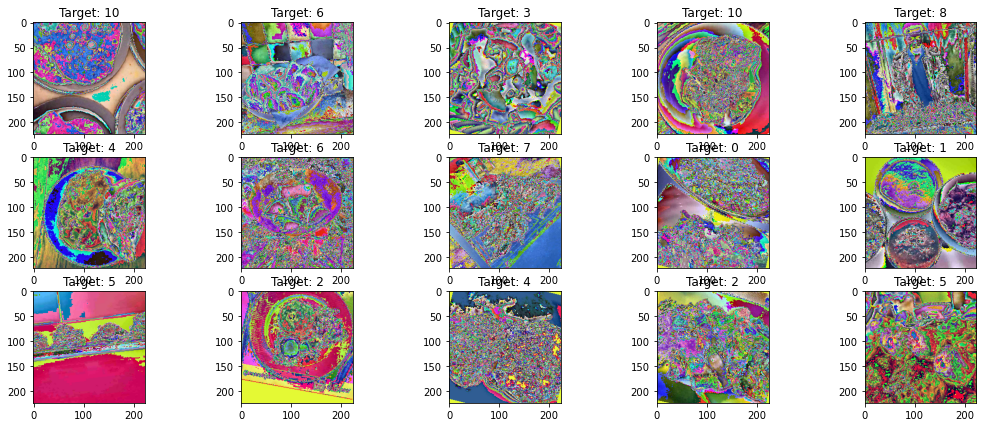


Test set: Average loss: 2.7851, Accuracy: 63/1308 (5%)

Initial Test Loss : 2.785060, 
Initial Test Accuracy : 4.817%

Epoch: 0 
Train Loss: 1.366053 Acc: 0.4899
Epoch 0  train loss 1.366053069221135
Global Epoch train loss len 1
Elapsed 113.47s, 113.47 s/epoch, 0.35 s/batch, ets 5559.91s

Test set: Average loss: 1.1197, Accuracy: 768/1308 (59%)

Epoch 0  test loss 1.1197439010550336
Global Epoch test loss len 1
Model Improved. Saving the Model...

Epoch: 1 
Train Loss: 0.727203 Acc: 0.7115
Epoch 1  train loss 0.7272031942456505
Global Epoch train loss len 2
Elapsed 256.86s, 128.43 s/epoch, 0.39 s/batch, ets 6164.65s

Test set: Average loss: 1.2130, Accuracy: 861/1308 (66%)

Epoch 1  test loss 1.2130485965711315
Global Epoch test loss len 2
Epoch: 2 
Train Loss: 0.550342 Acc: 0.7810
Epoch 2  train loss 0.5503419363808559
Global Epoch train loss len 3
Elapsed 398.10s, 132.70 s/epoch, 0.41 s/batch, ets 6236.87s

Test set: Average loss: 1.1167, Accuracy: 871/1308 (67%)

Epoch 2  test los

In [ ]:
import time
model, train_loader, test_loader, epoch_train_loss, epoch_test_loss, epoch_train_acc, epoch_test_acc = main(model, optimizer, scheduler=scheduler)

train acc len 50
test acc len 50
train loss len 50
test loss len 50


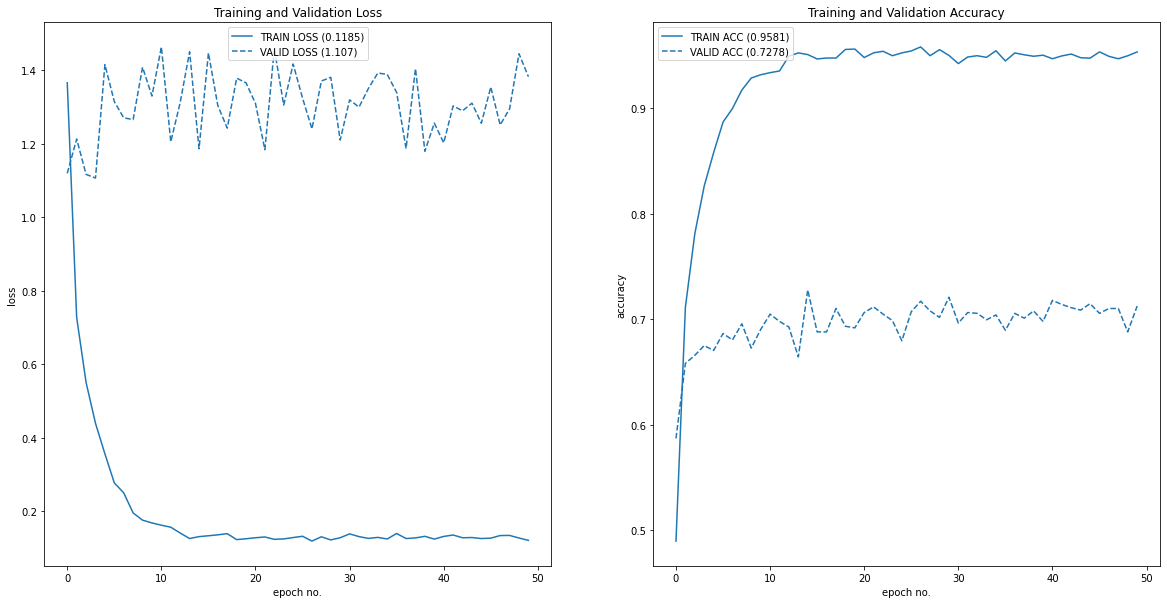

In [ ]:
print("train acc len {}".format(len(epoch_train_acc)))
print("test acc len {}".format(len(epoch_test_acc)))
print("train loss len {}".format(len(epoch_train_loss)))
print("test loss len {}".format(len(epoch_test_loss)))

      
plot_loss_accuracy(train_loss=[epoch_train_loss], 
                   val_loss=[epoch_test_loss], 
                   train_acc=[epoch_train_acc], 
                   val_acc=[epoch_test_acc], 
                   colors=['blue'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

In [ ]:
save_model(model, 'cuda')

In [ ]:
def prediction(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

**Generate Sample Submission**

In [ ]:
class KenyanFood13DatasetTest(Dataset):
    """

    """

    def __init__(self, data_root, transform=None):
        image_csv_path = os.path.join(data_root, 'test.csv')
        self.image_df = pd.read_csv(image_csv_path)
        print("Number test samples {}".format(len(self.image_df)))
        
        # set transform attribute
        self.transform = transform
        
        self.data_dict = {
            'image_path': [],
            'img_name': []
        }
        
        img_dir = os.path.join(data_root, 'images', 'images')

        for index, row in self.image_df.iterrows():
            img_path = os.path.join(img_dir, '{}.jpg'.format(row[0]))
            self.data_dict['image_path'].append(img_path)
            self.data_dict['img_name'].append(row[0])

    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing.
        """
        
        image = Image.open(self.data_dict['image_path'][idx]).convert("RGB")
        
        if self.transform is not None:
            image = self.transform(image)
            
        img_name = self.data_dict['img_name'][idx]
            
        return image, img_name
    
    def __len__(self):
        return len(self.data_dict['img_name'])

In [ ]:
image_csv_path = os.path.join(data_root, 'test.csv')
image_df = pd.read_csv(image_csv_path)
print("Number test samples {}".format(len(self.image_df)))

NameError: name 'data_root' is not defined

In [ ]:
test_dataset =  KenyanFood13DatasetTest(DATA_ROOT, transform=image_common_transforms())
data_len = test_dataset.__len__()
print("Test data length is {}".format(data_len))

Number test samples 1638
Test data length is 1638


In [ ]:
model = load_model(model)

classes_labels = {}

reader = csv.reader(open('./labels.csv'))


for row in reader:
    key = row[0]
    if key in classes_labels:
        # implement your duplicate row handling here
        pass
    classes_labels[int(key)] = row[1]
print(classes_labels)

submit_data = {}

inputs = []

for i in range(data_len):
    img, img_name = test_dataset.__getitem__(i)
    inputs.append(img)
    
    inputs = torch.stack(inputs)
    
    cls, prob = prediction(model, 'cuda', batch_input=inputs)
    submit_data[img_name] = classes_labels[cls]
    inputs.clear()
    
    
with open('./submission.csv', 'w') as f:
    for key in submit_data.keys():
        f.write("%s,%s\n"%(key,submit_data[key]))
        
print(submit_data)

{0: 'githeri', 1: 'ugali', 2: 'kachumbari', 3: 'matoke', 4: 'sukumawiki', 5: 'bhaji', 6: 'mandazi', 7: 'kukuchoma', 8: 'nyamachoma', 9: 'pilau', 10: 'chapati', 11: 'masalachips', 12: 'mukimo'}


TypeError: unhashable type: 'numpy.ndarray'